# **Import modules**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# **Load Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/star_classification.csv")
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

In [ ]:
df['class'].unique()

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [ ]:

input_cols = ['u', 'g', 'r', 'i', 'z', 'redshift']
X = df[input_cols].values  # shape (N, 6)

#  Encode class labels (e.g., STAR=0, GALAXY=1, QSO=2)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['class'])  # shape (N,)

#  Normalize inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)

# **Dataset class**

In [ ]:

class StarDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(StarDataset(X, y), batch_size=32, shuffle=True)

# **The Expert**

In [ ]:

class Expert(nn.Module):
    def __init__(self, inp_dim, hid_dim, out_dim, dropout=0.1, use_norm=True):
        super().__init__()
        self.fc1 = nn.Linear(inp_dim, hid_dim)
        self.norm1 = nn.LayerNorm(hid_dim) if use_norm else nn.Identity()
        self.dropout = nn.Dropout(dropout)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hid_dim, out_dim)
        self.norm2 = nn.LayerNorm(out_dim) if use_norm else nn.Identity()

    def forward(self, x):
        x = self.dropout(self.act(self.norm1(self.fc1(x))))
        return self.norm2(self.fc2(x))

# **The Router**

In [ ]:

class Router(nn.Module):
    def __init__(self, inp_dim, n_experts, routing_type='softmax', top_k=2, noisy=False, noise_std=1.0):
        super().__init__()
        assert routing_type in ['softmax', 'topk'], "routing_type must be 'softmax' or 'topk'"
        self.fc = nn.Linear(inp_dim, n_experts)
        self.routing_type = routing_type
        self.top_k = top_k
        self.noisy = noisy
        self.noise_std = noise_std

    def forward(self, x, return_logits=False):
        logits = self.fc(x)  # [B, n_experts]

        if self.noisy:
            noise = torch.randn_like(logits) * self.noise_std
            logits = logits + noise

        if self.routing_type == 'softmax':
            scores = F.softmax(logits, dim=-1)  # [B, n_experts]
            return (scores, logits) if return_logits else scores

        elif self.routing_type == 'topk':
            scores = F.softmax(logits, dim=-1)  # apply softmax first
            top_k_vals, top_k_indices = torch.topk(scores, k=self.top_k, dim=-1)  # [B, k], [B, k]
            top_k_vals = top_k_vals / (top_k_vals.sum(dim=-1, keepdim=True) + 1e-9)  # normalize
            return ((top_k_indices, top_k_vals), logits) if return_logits else (top_k_indices, top_k_vals)


# **The Mixture of Experts model**

In [ ]:
# 5. MoE
class Mixture_of_Experts(nn.Module):
    def __init__(self, inp_dim, hid_dim, out_dim, n_experts, k=2, routing_type='topk'):
        super().__init__()
        self.n_experts = n_experts
        self.k = k
        self.routing_type = routing_type
        self.experts = nn.ModuleList([Expert(inp_dim, hid_dim, out_dim) for _ in range(n_experts)])
        self.router = Router(inp_dim, n_experts, routing_type=routing_type, top_k=k)

    def forward(self, x):
        if self.routing_type == 'softmax':
            scores = self.router(x)  # (B, n_experts)
            expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
            return (expert_outputs * scores.unsqueeze(-1)).sum(dim=1)
        else:
            idxs, vals = self.router(x)
            all_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
            selected = torch.gather(all_outputs, 1, idxs.unsqueeze(-1).expand(-1, -1, all_outputs.shape[-1]))
            return (selected * vals.unsqueeze(-1)).sum(dim=1)


# **Initialize the Model, Criterion, and Optimizer**

In [ ]:
inp_dim = X.shape[1]
hid_dim = 128
out_dim = len(np.unique(y))
n_experts = 8
k = 2

moe_model_topk = Mixture_of_Experts(
    inp_dim, hid_dim, out_dim, n_experts, k, routing_type='topk'
)
moe_model_softmax = Mixture_of_Experts(
    inp_dim, hid_dim, out_dim, n_experts, k, routing_type='topk'
)
criterion = nn.CrossEntropyLoss()

optimizer_topk = torch.optim.Adam(moe_model_topk.parameters(), lr=1e-3)
optimizer_softmax = torch.optim.Adam(moe_model_softmax.parameters(), lr=1e-3)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **Training the MoE model**

In [ ]:
def train_mixture_of_experts(model, dataloader, criterion, optimizer, n_epochs=10, device='cpu'):
    model.to(device)
    model.train()
    for epoch in range(n_epochs):
        total_loss = 0.0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(dataloader):.4f}")

In [ ]:
print("\n Training using Soft-gating.....")
train_mixture_of_experts(moe_model_softmax, train_loader, criterion, optimizer_softmax, n_epochs=100, device=device)

print("\n Training using Top-k gating.....")
train_mixture_of_experts(moe_model_topk, train_loader, criterion, optimizer_topk, n_epochs=100, device=device)




 Training using Soft-gating.....
Epoch 1: Loss = 0.1954
Epoch 2: Loss = 0.1229
Epoch 3: Loss = 0.1157
Epoch 4: Loss = 0.1104
Epoch 5: Loss = 0.1068
Epoch 6: Loss = 0.1073
Epoch 7: Loss = 0.1046
Epoch 8: Loss = 0.1032
Epoch 9: Loss = 0.1034
Epoch 10: Loss = 0.1022
Epoch 11: Loss = 0.1015
Epoch 12: Loss = 0.1012
Epoch 13: Loss = 0.1011
Epoch 14: Loss = 0.0994
Epoch 15: Loss = 0.0984
Epoch 16: Loss = 0.0991
Epoch 17: Loss = 0.0975
Epoch 18: Loss = 0.0974
Epoch 19: Loss = 0.0968
Epoch 20: Loss = 0.0980
Epoch 21: Loss = 0.0967
Epoch 22: Loss = 0.0971
Epoch 23: Loss = 0.0961
Epoch 24: Loss = 0.0953
Epoch 25: Loss = 0.0954
Epoch 26: Loss = 0.0955
Epoch 27: Loss = 0.0965
Epoch 28: Loss = 0.0952
Epoch 29: Loss = 0.0947
Epoch 30: Loss = 0.0941
Epoch 31: Loss = 0.0942
Epoch 32: Loss = 0.0943
Epoch 33: Loss = 0.0946
Epoch 34: Loss = 0.0942
Epoch 35: Loss = 0.0949
Epoch 36: Loss = 0.0932
Epoch 37: Loss = 0.0936
Epoch 38: Loss = 0.0927
Epoch 39: Loss = 0.0926
Epoch 40: Loss = 0.0913
Epoch 41: Loss 

# **Visualization of expert-usage**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_expert_specialization_side_by_side(model_softmax=None, model_topk=None, dataloader=None, device='cpu', class_names=None):
    def get_distribution(model):
        model.eval()
        model.to(device)

        n_classes = len(torch.unique(next(iter(dataloader))[1]))
        expert_class_counts = torch.zeros((model.n_experts, n_classes), device=device)

        with torch.no_grad():
            for inps, tgts in dataloader:
                inps, tgts = inps.to(device), tgts.to(device)
                if model.routing_type == 'softmax':
                    router_scores = model.router(inps)
                    if isinstance(router_scores, tuple):
                        router_scores = router_scores[0]
                    max_experts = torch.argmax(router_scores, dim=-1)
                else:
                    topk_indices, _ = model.router(inps)
                    max_experts = topk_indices[:, 0]

                for expert_idx, label in zip(max_experts, tgts):
                    expert_class_counts[expert_idx, label] += 1

        dist = expert_class_counts.cpu().numpy()
        row_sums = dist.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # Prevent divide-by-zero
        dist = dist / row_sums
        return dist, expert_class_counts.cpu().numpy(), n_classes

    n_models = int(model_softmax is not None) + int(model_topk is not None)
    if n_models == 0:
        raise ValueError("At least one of model_softmax or model_topk must be provided.")

    n_classes = len(torch.unique(next(iter(dataloader))[1]))
    if class_names is None:
        class_names = [f"Class {i}" for i in range(n_classes)]

    fig, axes = plt.subplots(1, n_models, figsize=(8 * n_models, 6), sharey=True)

    if n_models == 1:
        axes = [axes]

    ax_idx = 0

    if model_softmax:
        dist_softmax, _, _ = get_distribution(model_softmax)
        bar_width = 0.8 / model_softmax.n_experts
        x = np.arange(n_classes)
        for i in range(model_softmax.n_experts):
            axes[ax_idx].bar(x + i * bar_width, dist_softmax[i], width=bar_width, label=f'Expert {i}')
        axes[ax_idx].set_title('Expert Specialization (softmax routing)')
        axes[ax_idx].set_xticks(x + bar_width * model_softmax.n_experts / 2)
        axes[ax_idx].set_xticklabels(class_names)
        axes[ax_idx].set_ylabel("Class Distribution per Expert")
        axes[ax_idx].legend(ncol=2, fontsize=8)
        ax_idx += 1

    if model_topk:
        dist_topk, _, _ = get_distribution(model_topk)
        bar_width = 0.8 / model_topk.n_experts
        x = np.arange(n_classes)
        for i in range(model_topk.n_experts):
            axes[ax_idx].bar(x + i * bar_width, dist_topk[i], width=bar_width, label=f'Expert {i}')
        axes[ax_idx].set_title('Expert Specialization (top-k routing)')
        axes[ax_idx].set_xticks(x + bar_width * model_topk.n_experts / 2)
        axes[ax_idx].set_xticklabels(class_names)
        axes[ax_idx].legend(ncol=2, fontsize=8)

    plt.tight_layout()
    plt.show()


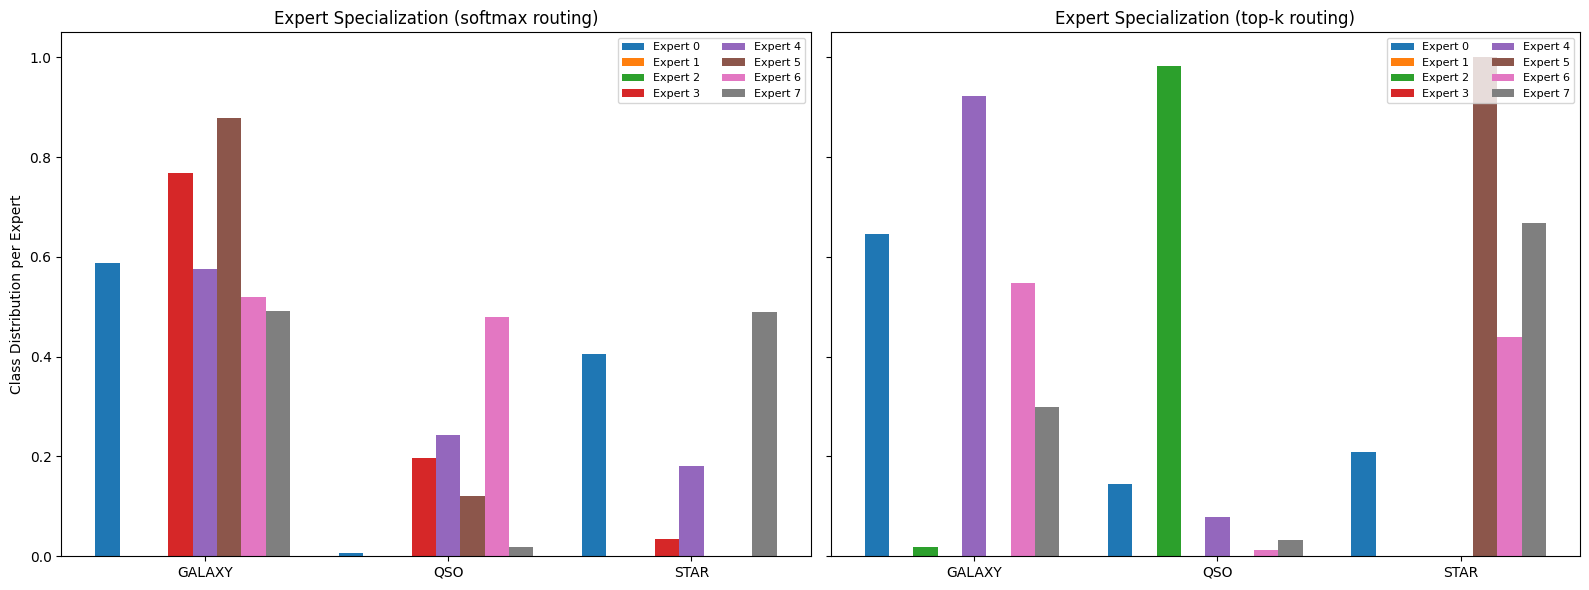

In [ ]:
visualize_expert_specialization_side_by_side(
    model_softmax=moe_model_softmax,
    model_topk=moe_model_topk,
    dataloader=train_loader,
    device=device,
    class_names=['GALAXY', 'QSO', 'STAR']
)


# **Load Balancing**

In [ ]:
def load_balancing_loss(router_scores):
    size_of_batch, n_experts = router_scores.shape
    mean_exp_usage = torch.mean(router_scores, dim=0)
    balancing_loss = - torch.sum(mean_exp_usage * torch.log(mean_exp_usage + 1e-10))
    return balancing_loss


In [ ]:
class Mixture_of_Experts_with_load_balancing(nn.Module):
    def __init__(self, inp_dim, hid_dim, out_dim, n_experts, k=2, routing_type='softmax'):
        super().__init__()
        self.n_experts = n_experts
        self.k = k
        self.routing_type = routing_type

        self.experts = nn.ModuleList([Expert(inp_dim, hid_dim, out_dim) for _ in range(n_experts)])
        self.router = Router(inp_dim, n_experts, routing_type, k)

    def forward(self, x, return_router_scores=True):
        if self.routing_type == 'softmax':
            router_scores = self.router(x)
            expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
            output = (expert_outputs * router_scores.unsqueeze(-1)).sum(dim=1)
            return (output, router_scores) if return_router_scores else output

        elif self.routing_type == 'topk':
            top_k_indices, top_k_vals = self.router(x)
            expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
            out_dim = expert_outputs.size(-1)
            topk_outputs = torch.gather(
                expert_outputs, dim=1,
                index=top_k_indices.unsqueeze(-1).expand(-1, -1, out_dim)
            )
            output = (topk_outputs * top_k_vals.unsqueeze(-1)).sum(dim=1)

            if return_router_scores:
                # Build full routing score matrix (sparse)
                scores = torch.zeros(x.size(0), self.n_experts, device=x.device)
                for b in range(x.size(0)):
                    scores[b, top_k_indices[b]] = top_k_vals[b]
                return output, scores

            return output


In [ ]:
def train_mixture_of_experts_with_load_balancing(model, dataloader, criterion, optimizer, n_epochs=20, device='cpu', alpha=0.01):
    model.train()
    model.to(device)

    for epoch in range(n_epochs):
        total_loss = 0.0
        for inps, tgts in dataloader:
            inps, tgts = inps.to(device), tgts.to(device)

            optimizer.zero_grad()
            outs, router_scores = model(inps, return_router_scores=True)
            loss_cls = criterion(outs, tgts)
            loss_balance = load_balancing_loss(router_scores)
            loss = loss_cls + alpha * loss_balance
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")


In [ ]:
inp_dim = 6
hid_dim = 128
out_dim = 3          # classes: STAR, GALAXY, QSO
n_experts = 8
k = 2

moe_model_topk_lb = Mixture_of_Experts_with_load_balancing(
    inp_dim=inp_dim,
    hid_dim=hid_dim,
    out_dim=out_dim,
    n_experts=n_experts,
    k=k,
    routing_type='topk'
)

print("\n Training using Top-k gating with load-balancing.....")

train_mixture_of_experts_with_load_balancing(
    model=moe_model_topk_lb,
    dataloader=train_loader,
    criterion=criterion,
    optimizer=optimizer_topk,
    n_epochs=100,
    device=device,
    alpha=0.01
)


 Training using Top-k gating with load-balancing.....
Epoch 1, Loss: 1.5167
Epoch 2, Loss: 1.5170
Epoch 3, Loss: 1.5168
Epoch 4, Loss: 1.5158
Epoch 5, Loss: 1.5165
Epoch 6, Loss: 1.5178
Epoch 7, Loss: 1.5146
Epoch 8, Loss: 1.5163
Epoch 9, Loss: 1.5152
Epoch 10, Loss: 1.5145
Epoch 11, Loss: 1.5157
Epoch 12, Loss: 1.5180
Epoch 13, Loss: 1.5165
Epoch 14, Loss: 1.5140
Epoch 15, Loss: 1.5151
Epoch 16, Loss: 1.5161
Epoch 17, Loss: 1.5193
Epoch 18, Loss: 1.5154
Epoch 19, Loss: 1.5162
Epoch 20, Loss: 1.5151
Epoch 21, Loss: 1.5162
Epoch 22, Loss: 1.5156
Epoch 23, Loss: 1.5151
Epoch 24, Loss: 1.5156
Epoch 25, Loss: 1.5172
Epoch 26, Loss: 1.5183
Epoch 27, Loss: 1.5163
Epoch 28, Loss: 1.5164
Epoch 29, Loss: 1.5142
Epoch 30, Loss: 1.5173
Epoch 31, Loss: 1.5165
Epoch 32, Loss: 1.5191
Epoch 33, Loss: 1.5163
Epoch 34, Loss: 1.5170
Epoch 35, Loss: 1.5156
Epoch 36, Loss: 1.5155
Epoch 37, Loss: 1.5144
Epoch 38, Loss: 1.5158
Epoch 39, Loss: 1.5171
Epoch 40, Loss: 1.5141
Epoch 41, Loss: 1.5176
Epoch 42, L

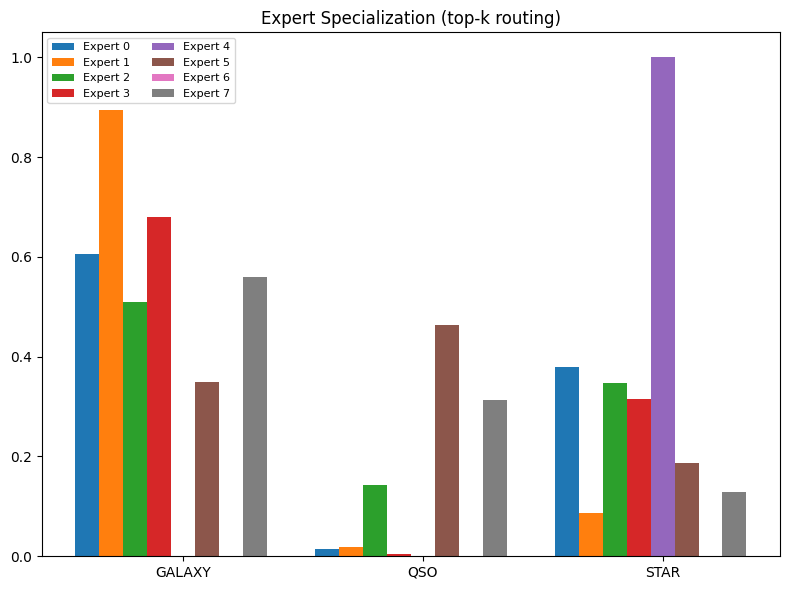

In [ ]:
visualize_expert_specialization_side_by_side(
    model_softmax=None,
    model_topk=moe_model_topk_lb,
    dataloader=train_loader,
    device=device,
    class_names=['GALAXY', 'QSO', 'STAR']
)
